觀察川普政策影響：
1. 4/7~4/14 波動
2. 3/27、3/28、3/31、4/1、4/2 發生前

加權指數每5秒更新、台灣VIX每15秒更新

每日、每小時、每分鐘

In [1]:
import UDP
import pandas as pd
import numpy as np
import binascii, os, glob, sys, time, datetime
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties as font
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei') # 在圖表上顯示中文
import matplotlib.ticker as mtick
from collections import Counter

ModuleNotFoundError: No module named 'UDP'

In [15]:
# === 1️⃣ 讀取 CSV 檔案 ===
file_path = "D:/加權指數/2~4月.csv"  # 檔案路徑
df = pd.read_csv(file_path, encoding='cp950', dtype=str)  # 避免數據類型問題

# === 2️⃣ 清理數據，確保收盤價為數值 ===
closing_price_col = df.columns[-1]  # 獲取最後一個欄位名稱
df["收盤價"] = df[closing_price_col].str.replace(",", "").astype(float)  # 確保數值型態

# === 3️⃣ 確保日期格式一致 ===
df["日期"] = df["日期"].str.replace("114/", "2025/")
df["日期"] = pd.to_datetime(df["日期"], format="%Y/%m/%d", errors="coerce")

# === 4️⃣ 計算日報酬 ===
df["log_return"] = np.log(df["收盤價"] / df["收盤價"].shift(1))
df["log_return"] = df["log_return"].fillna(0)  # 填充 NaN

# === 5️⃣ 顯示結果 ===
print(df[["日期", "收盤價", "log_return"]])  # 顯示日期、收盤價與日報酬


           日期       收盤價  log_return
0  2025-02-03  22694.71    0.000000
1  2025-02-04  22793.96    0.004364
2  2025-02-05  23161.58    0.015999
3  2025-02-06  23316.60    0.006671
4  2025-02-07  23478.27    0.006910
5  2025-02-10  23252.14   -0.009678
6  2025-02-11  23384.05    0.005657
7  2025-02-12  23289.75   -0.004041
8  2025-02-13  23399.41    0.004697
9  2025-02-14  23152.61   -0.010603
10 2025-02-17  23505.33    0.015120
11 2025-02-18  23666.11    0.006817
12 2025-02-19  23604.08   -0.002624
13 2025-02-20  23487.46   -0.004953
14 2025-02-21  23730.25    0.010284
15 2025-02-24  23565.31   -0.006975
16 2025-02-25  23285.72   -0.011935
17 2025-02-26  23402.55    0.005005
18 2025-02-27  23053.18   -0.015041
19 2025-03-03  22756.25   -0.012964
20 2025-03-04  22596.88   -0.007028
21 2025-03-05  22871.90    0.012097
22 2025-03-06  22715.43   -0.006865
23 2025-03-07  22576.07   -0.006154
24 2025-03-10  22459.15   -0.005192
25 2025-03-11  22071.09   -0.017429
26 2025-03-12  22278.36    0

In [26]:

# === 3️⃣ 計算 20 天的歷史波動率（HV） ===
window_size = 20  # 20 天窗口
df["hv"] = df["log_return"].rolling(window=window_size).std()

# === 4️⃣ 年化波動率 ===
annual_factor = np.sqrt(252)  # 252 個交易日（年化）
df["hv_annualized"] = df["hv"] * annual_factor * 100  # 轉換為百分比表示

# === 1️⃣ 只保留 3 月 ~ 4 月的數據 ===
df_filtered = df[(df["日期"] >= "2025-03-01") & (df["日期"] <= "2025-04-30")].copy()
df_filtered = df_filtered.sort_values("日期")  # 確保時間排序

# === 5️⃣ 顯示結果 ===
print(df_filtered[["日期", "收盤價", "log_return", "hv", "hv_annualized"]])  # 顯示計算結果
df_filtered['交易日期']  = df_filtered['日期']


           日期       收盤價  log_return        hv  hv_annualized
19 2025-03-03  22756.25   -0.012964  0.009364      14.865281
20 2025-03-04  22596.88   -0.007028  0.009500      15.081527
21 2025-03-05  22871.90    0.012097  0.009848      15.632757
22 2025-03-06  22715.43   -0.006865  0.009221      14.637313
23 2025-03-07  22576.07   -0.006154  0.009106      14.455893
24 2025-03-10  22459.15   -0.005192  0.008910      14.144413
25 2025-03-11  22071.09   -0.017429  0.009406      14.932258
26 2025-03-12  22278.36    0.009347  0.009611      15.257031
27 2025-03-13  21961.68   -0.014317  0.009970      15.827021
28 2025-03-14  21968.05    0.000290  0.009840      15.621076
29 2025-03-17  22118.63    0.006831  0.009918      15.744067
30 2025-03-18  22271.67    0.006895  0.009310      14.779345
31 2025-03-19  21960.83   -0.014055  0.009357      14.854398
32 2025-03-20  22377.26    0.018785  0.010630      16.874150
33 2025-03-21  22209.10   -0.007543  0.010675      16.945554
34 2025-03-24  22106.64 

In [2]:
def load_stock_data(tick_folder, files):
    """ 讀取PCP資料+每日日內tick資料 """
    y=df_list = [pd.read_csv(f"{tick_folder}/{f[:-4]}.csv", encoding='cp950', low_memory = False) for f in files]
    combined_df = pd.concat(df_list, ignore_index=True)  # 合併多個 DataFrame
    
    return combined_df

In [3]:
stock_folder = 'D:/加權指數'
files = ['0303.csv', '0304.csv', '0305.csv', '0306.csv', '0307.csv',
         '0310.csv', '0311.csv', '0312.csv', '0313.csv', '0314.csv',
         '0317.csv', '0318.csv', '0319.csv', '0320.csv', '0321.csv',
         '0324.csv', '0325.csv',  '0326.csv', '0327.csv', '0328.csv',
         '0331.csv', '0401.csv', '0402.csv', 
         '0407.csv', '0408.csv', '0409.csv', '0410.csv', '0411.csv', 
         '0414.csv', '0415.csv', '0416.csv', '0417.csv', '0418.csv',
         '0421.csv', '0422.csv', '0423.csv', '0424.csv', '0425.csv',
         '0428.csv', '0429.csv', '0430.csv']
dfs = load_stock_data(stock_folder, files)

df_stock = dfs[['日期', '時間', '發行量加權股價指數']]
df_stock['date'] = '2025年' + df_stock['日期']  # 加上年份，變成 "2025年3月26日"
df_stock['date'] = pd.to_datetime(df_stock['date'], format='%Y年%m月%d日')
df_stock['date_str'] = df_stock['date'].dt.strftime('%Y-%m-%d')
df_stock['datetime'] = pd.to_datetime(df_stock['date_str'] + ' ' + df_stock['時間'], format="%Y-%m-%d %H:%M:%S")
df_stock['發行量加權股價指數'] = df_stock['發行量加權股價指數'].str.replace(',', '').astype(float)
df_stock

C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_8424\3959396130.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock['date'] = '2025年' + df_stock['日期']  # 加上年份，變成 "2025年3月26日"
C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_8424\3959396130.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock['date'] = pd.to_datetime(df_stock['date'], format='%Y年%m月%d日')
C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_8424\3959396130.py:16: SettingWithCopyWarning: 
A value is trying to be set

,日期,時間,發行量加權股價指數,date,date_str,datetime
0,3月3日,09:00:00,23053.18,2025-03-03,2025-03-03,2025-03-03 09:00:00
1,3月3日,09:00:05,22734.05,2025-03-03,2025-03-03,2025-03-03 09:00:05
2,3月3日,09:00:10,22682.02,2025-03-03,2025-03-03,2025-03-03 09:00:10
3,3月3日,09:00:15,22643.49,2025-03-03,2025-03-03,2025-03-03 09:00:15
4,3月3日,09:00:20,22642.09,2025-03-03,2025-03-03,2025-03-03 09:00:20
...,...,...,...,...,...,...
132876,4月30日,13:29:40,20213.47,2025-04-30,2025-04-30,2025-04-30 13:29:40
132877,4月30日,13:29:45,20213.47,2025-04-30,2025-04-30,2025-04-30 13:29:45
132878,4月30日,13:29:50,20213.47,2025-04-30,2025-04-30,2025-04-30 13:29:50
132879,4月30日,13:29:55,20213.47,2025-04-30,2025-04-30,2025-04-30 13:29:55


In [6]:
# === 只取每天 13:30 的收盤價 ===
df_closing = df_stock[df_stock["時間"] == "13:30:00"].copy()

# 確保數據排序
df_closing = df_closing.sort_values("datetime")

# 顯示結果
print(df_closing)


           日期        時間  發行量加權股價指數       date    date_str            datetime
3240     3月3日  13:30:00   22756.25 2025-03-03  2025-03-03 2025-03-03 13:30:00
6481     3月4日  13:30:00   22596.88 2025-03-04  2025-03-04 2025-03-04 13:30:00
9722     3月5日  13:30:00   22871.90 2025-03-05  2025-03-05 2025-03-05 13:30:00
12963    3月6日  13:30:00   22715.43 2025-03-06  2025-03-06 2025-03-06 13:30:00
16204    3月7日  13:30:00   22576.07 2025-03-07  2025-03-07 2025-03-07 13:30:00
19445   3月10日  13:30:00   22459.15 2025-03-10  2025-03-10 2025-03-10 13:30:00
22686   3月11日  13:30:00   22071.09 2025-03-11  2025-03-11 2025-03-11 13:30:00
25927   3月12日  13:30:00   22278.36 2025-03-12  2025-03-12 2025-03-12 13:30:00
29168   3月13日  13:30:00   21961.68 2025-03-13  2025-03-13 2025-03-13 13:30:00
32409   3月14日  13:30:00   21968.05 2025-03-14  2025-03-14 2025-03-14 13:30:00
35650   3月17日  13:30:00   22118.63 2025-03-17  2025-03-17 2025-03-17 13:30:00
38891   3月18日  13:30:00   22271.67 2025-03-18  2025-03-18 2025-0

In [7]:
import pandas as pd
import numpy as np

# === 1️⃣ 只取每天 13:30 的收盤價 ===
df_closing = df_stock[df_stock["時間"] == "13:30:00"].copy()
df_closing = df_closing.sort_values("datetime")  # 確保按時間排序

# === 2️⃣ 計算日報酬 ===
df_closing["log_return"] = np.log(df_closing["發行量加權股價指數"] / df_closing["發行量加權股價指數"].shift(1))
df_closing["log_return"] = df_closing["log_return"].fillna(0)  # 填充 NaN

# === 3️⃣ 計算 20 天的歷史波動率（HV） ===
window_size = 20  # 20 天窗口
df_closing["hv"] = df_closing["log_return"].rolling(window=window_size).std()

# === 4️⃣ 年化波動率 ===
annual_factor = np.sqrt(252)  # 252 個交易日（年化）
df_closing["hv_annualized"] = df_closing["hv"] * annual_factor * 100  # 轉換為百分比表示

# === 5️⃣ 顯示結果 ===
print(df_closing[["datetime", "發行量加權股價指數", "log_return", "hv", "hv_annualized"]])


                  datetime  發行量加權股價指數  log_return        hv  hv_annualized
3240   2025-03-03 13:30:00   22756.25    0.000000       NaN            NaN
6481   2025-03-04 13:30:00   22596.88   -0.007028       NaN            NaN
9722   2025-03-05 13:30:00   22871.90    0.012097       NaN            NaN
12963  2025-03-06 13:30:00   22715.43   -0.006865       NaN            NaN
16204  2025-03-07 13:30:00   22576.07   -0.006154       NaN            NaN
19445  2025-03-10 13:30:00   22459.15   -0.005192       NaN            NaN
22686  2025-03-11 13:30:00   22071.09   -0.017429       NaN            NaN
25927  2025-03-12 13:30:00   22278.36    0.009347       NaN            NaN
29168  2025-03-13 13:30:00   21961.68   -0.014317       NaN            NaN
32409  2025-03-14 13:30:00   21968.05    0.000290       NaN            NaN
35650  2025-03-17 13:30:00   22118.63    0.006831       NaN            NaN
38891  2025-03-18 13:30:00   22271.67    0.006895       NaN            NaN
42132  2025-03-19 13:30:0

每天的報酬去算，
20日的年化波動率 ()

In [4]:
df_stock_min = df_stock[df_stock['datetime'].dt.strftime('%S') == '00']  # 只選擇秒數為 00 的數據
df_filtered = df_stock_min.copy()
# === 3. 計算 Log Return ===
df_filtered['log_return'] = np.log(df_filtered['發行量加權股價指數'] / df_filtered['發行量加權股價指數'].shift(1))
df_filtered['log_return'] = df_filtered['log_return'].fillna(0)
window_size = 60  # 60分鐘窗口
df_filtered['hv'] = df_filtered['log_return'].rolling(window=window_size).std()

# 年化波動率
annual_factor = np.sqrt(252 * 60)  # 252個交易日 & 每天60筆
df_filtered['hv_annualized'] = df_filtered['hv'] * annual_factor 
df_filtered = df_filtered[df_filtered['datetime'].dt.strftime('%Y-%m-%d') != '2025-03-25']
df_filtered['hv'] = df_filtered['hv'] * 100
df_filtered['hv_annualized'] = df_filtered['hv_annualized'] * 100
df_stock = df_filtered
df_stock


,日期,時間,發行量加權股價指數,date,date_str,datetime,log_return,hv,hv_annualized
0,3月3日,09:00:00,23053.18,2025-03-03,2025-03-03,2025-03-03 09:00:00,0.000000e+00,NaN,NaN
12,3月3日,09:01:00,22665.58,2025-03-03,2025-03-03,2025-03-03 09:01:00,-1.695625e-02,NaN,NaN
24,3月3日,09:02:00,22633.18,2025-03-03,2025-03-03,2025-03-03 09:02:00,-1.430503e-03,NaN,NaN
36,3月3日,09:03:00,22631.06,2025-03-03,2025-03-03,2025-03-03 09:03:00,-9.367218e-05,NaN,NaN
48,3月3日,09:04:00,22732.19,2025-03-03,2025-03-03,2025-03-03 09:04:00,4.458683e-03,NaN,NaN
...,...,...,...,...,...,...,...,...,...
132832,4月30日,13:26:00,20213.47,2025-04-30,2025-04-30,2025-04-30 13:26:00,9.894397e-07,0.032278,3.969070
132844,4月30日,13:27:00,20213.47,2025-04-30,2025-04-30,2025-04-30 13:27:00,0.000000e+00,0.032277,3.968922
132856,4月30日,13:28:00,20213.47,2025-04-30,2025-04-30,2025-04-30 13:28:00,0.000000e+00,0.032277,3.968880
132868,4月30日,13:29:00,20213.47,2025-04-30,2025-04-30,2025-04-30 13:29:00,0.000000e+00,0.032258,3.966567


In [20]:
df_vix = pd.read_csv('D:\台灣VIX\台灣VIX.csv', encoding='cp950', low_memory = False)
df_vix

,交易日期,時間(時/分/秒/毫秒),臺指選擇權波動率指數
0,20250303,9000000,21.64
1,20250303,9001500,21.84
2,20250303,9003000,21.86
3,20250303,9004500,21.82
4,20250303,9010000,21.75
...,...,...,...
45635,20250429,13440000,28.84
45636,20250429,13441500,28.85
45637,20250429,13443000,28.85
45638,20250429,13444500,28.84


In [21]:
# === 1. 確保數據類型正確 ===
df_vix['交易日期'] = df_vix['交易日期'].astype(str)  # 確保交易日期為字串
df_vix['時間(時/分/秒/毫秒)'] = df_vix['時間(時/分/秒/毫秒)'].astype(str).str.zfill(8)  # 確保時間格式為8位數

# === 2. 轉換日期格式 ===
df_vix['交易日期'] = pd.to_datetime(df_vix['交易日期'], format='%Y%m%d')  # 轉換為標準日期格式

# === 3. 轉換時間格式（補足位數，確保 HH:MM:SS）===
df_vix['時間轉換'] = df_vix['時間(時/分/秒/毫秒)'].apply(lambda x: f"{x[:2]}:{x[2:4]}:{x[4:6]}")

# === 4. 合併日期與時間 ===
df_vix['datetime'] = df_vix['交易日期'].dt.strftime('%Y-%m-%d') + ' ' + df_vix['時間轉換']

# === 5. 確保 datetime 欄位為標準格式 ===
df_vix['datetime'] = pd.to_datetime(df_vix['datetime'], format='%Y-%m-%d %H:%M:%S')

df_vix = df_vix[df_vix['datetime'].dt.strftime('%S') == '00']  # 只選擇秒數為 00 的數據
df_vix


,交易日期,時間(時/分/秒/毫秒),臺指選擇權波動率指數,時間轉換,datetime
0,2025-03-03,09000000,21.64,09:00:00,2025-03-03 09:00:00
4,2025-03-03,09010000,21.75,09:01:00,2025-03-03 09:01:00
8,2025-03-03,09020000,21.63,09:02:00,2025-03-03 09:02:00
12,2025-03-03,09030000,21.57,09:03:00,2025-03-03 09:03:00
16,2025-03-03,09040000,21.51,09:04:00,2025-03-03 09:04:00
...,...,...,...,...,...
45623,2025-04-29,13410000,28.85,13:41:00,2025-04-29 13:41:00
45627,2025-04-29,13420000,28.83,13:42:00,2025-04-29 13:42:00
45631,2025-04-29,13430000,28.84,13:43:00,2025-04-29 13:43:00
45635,2025-04-29,13440000,28.84,13:44:00,2025-04-29 13:44:00


In [22]:
# 篩選每天 13:30:00 的數據
df_vix_filtered = df_vix[df_vix["時間轉換"] == "13:30:00"].copy()  # 13:30 對應的時間格式

# 確保數據排序
df_vix_filtered = df_vix_filtered.sort_values("交易日期")

# 顯示結果
print(df_vix_filtered)

            交易日期 時間(時/分/秒/毫秒)  臺指選擇權波動率指數      時間轉換            datetime
1080  2025-03-03     13300000       20.82  13:30:00 2025-03-03 13:30:00
2221  2025-03-04     13300000       22.02  13:30:00 2025-03-04 13:30:00
3362  2025-03-05     13300000       21.18  13:30:00 2025-03-05 13:30:00
4503  2025-03-06     13300000       21.24  13:30:00 2025-03-06 13:30:00
5644  2025-03-07     13300000       22.54  13:30:00 2025-03-07 13:30:00
6785  2025-03-10     13300000       22.22  13:30:00 2025-03-10 13:30:00
7926  2025-03-11     13300000       23.76  13:30:00 2025-03-11 13:30:00
9067  2025-03-12     13300000       22.61  13:30:00 2025-03-12 13:30:00
10208 2025-03-13     13300000       22.79  13:30:00 2025-03-13 13:30:00
11349 2025-03-14     13300000       23.01  13:30:00 2025-03-14 13:30:00
12490 2025-03-17     13300000       22.12  13:30:00 2025-03-17 13:30:00
13631 2025-03-18     13300000       21.24  13:30:00 2025-03-18 13:30:00
14772 2025-03-19     13300000       21.50  13:30:00 2025-03-19 1

In [27]:
# 合併兩個 DataFrame（根據 datetime 欄位）
df_merged = pd.merge(df_filtered, df_vix_filtered, on='交易日期', how='inner')
df_merged

,日期,開盤指數,最高指數,最低指數,收盤指數,收盤價,log_return,hv,hv_annualized,交易日期,時間(時/分/秒/毫秒),臺指選擇權波動率指數,時間轉換,datetime
0,2025-03-03,"22,734.05","22,775.02","22,611.10","22,756.25",22756.25,-0.012964,0.009364,14.865281,2025-03-03,13300000,20.82,13:30:00,2025-03-03 13:30:00
1,2025-03-04,"22,508.80","22,700.94","22,359.50","22,596.88",22596.88,-0.007028,0.009500,15.081527,2025-03-04,13300000,22.02,13:30:00,2025-03-04 13:30:00
2,2025-03-05,"22,778.86","22,948.30","22,757.22","22,871.90",22871.90,0.012097,0.009848,15.632757,2025-03-05,13300000,21.18,13:30:00,2025-03-05 13:30:00
3,2025-03-06,"22,930.11","22,979.97","22,715.43","22,715.43",22715.43,-0.006865,0.009221,14.637313,2025-03-06,13300000,21.24,13:30:00,2025-03-06 13:30:00
4,2025-03-07,"22,696.23","22,747.11","22,542.08","22,576.07",22576.07,-0.006154,0.009106,14.455893,2025-03-07,13300000,22.54,13:30:00,2025-03-07 13:30:00
5,2025-03-10,"22,548.98","22,641.25","22,407.57","22,459.15",22459.15,-0.005192,0.008910,14.144413,2025-03-10,13300000,22.22,13:30:00,2025-03-10 13:30:00
6,2025-03-11,"22,126.06","22,140.39","21,769.57","22,071.09",22071.09,-0.017429,0.009406,14.932258,2025-03-11,13300000,23.76,13:30:00,2025-03-11 13:30:00
7,2025-03-12,"22,171.10","22,391.47","22,153.61","22,278.36",22278.36,0.009347,0.009611,15.257031,2025-03-12,13300000,22.61,13:30:00,2025-03-12 13:30:00
8,2025-03-13,"22,403.34","22,552.43","21,961.68","21,961.68",21961.68,-0.014317,0.009970,15.827021,2025-03-13,13300000,22.79,13:30:00,2025-03-13 13:30:00
9,2025-03-14,"21,986.81","22,074.03","21,895.90","21,968.05",21968.05,0.000290,0.009840,15.621076,2025-03-14,13300000,23.01,13:30:00,2025-03-14 13:30:00


In [9]:
# 確保 datetime 欄位為正確的時間格式
df_filtered = df_merged.copy()
df_filtered['datetime'] = pd.to_datetime(df_filtered['datetime'])

# 只保留時間為 13:30:00 的數據
df_close = df_filtered[df_filtered['datetime'].dt.strftime('%H:%M:%S') == '13:30:00'].copy()

# 顯示結果
print(df_close[['datetime', '發行量加權股價指數']])


                 datetime  發行量加權股價指數
270   2025-03-03 13:30:00   22756.25
541   2025-03-04 13:30:00   22596.88
812   2025-03-05 13:30:00   22871.90
1083  2025-03-06 13:30:00   22715.43
1354  2025-03-07 13:30:00   22576.07
1625  2025-03-10 13:30:00   22459.15
1896  2025-03-11 13:30:00   22071.09
2167  2025-03-12 13:30:00   22278.36
2438  2025-03-13 13:30:00   21961.68
2709  2025-03-14 13:30:00   21968.05
2980  2025-03-17 13:30:00   22118.63
3251  2025-03-18 13:30:00   22271.67
3522  2025-03-19 13:30:00   21960.83
3793  2025-03-20 13:30:00   22377.26
4064  2025-03-21 13:30:00   22209.10
4335  2025-03-24 13:30:00   22106.64
4606  2025-03-26 13:30:00   22260.29
4877  2025-03-27 13:30:00   21951.76
5148  2025-03-28 13:30:00   21602.89
5419  2025-03-31 13:30:00   20695.90
5690  2025-04-01 13:30:00   21280.17
5961  2025-04-02 13:30:00   21298.22
6232  2025-04-07 13:30:00   19232.35
6503  2025-04-08 13:30:00   18459.95
6774  2025-04-09 13:30:00   17391.76
7045  2025-04-10 13:30:00   19000.03
7

In [12]:
df_filtered

,日期,時間,發行量加權股價指數,date,date_str,datetime,log_return,hv,hv_annualized,交易日期,時間(時/分/秒/毫秒),臺指選擇權波動率指數,時間轉換
270,3月3日,13:30:00,22756.25,2025-03-03,2025-03-03,2025-03-03 13:30:00,0.003659,0.098774,12.145572,2025-03-03,13300000,20.82,13:30:00
541,3月4日,13:30:00,22596.88,2025-03-04,2025-03-04,2025-03-04 13:30:00,-0.002305,0.131288,16.143616,2025-03-04,13300000,22.02,13:30:00
812,3月5日,13:30:00,22871.90,2025-03-05,2025-03-05,2025-03-05 13:30:00,-0.002510,0.115867,14.247390,2025-03-05,13300000,21.18,13:30:00
1083,3月6日,13:30:00,22715.43,2025-03-06,2025-03-06,2025-03-06 13:30:00,-0.004658,0.138890,17.078410,2025-03-06,13300000,21.24,13:30:00
1354,3月7日,13:30:00,22576.07,2025-03-07,2025-03-07,2025-03-07 13:30:00,0.001088,0.108091,13.291276,2025-03-07,13300000,22.54,13:30:00
1625,3月10日,13:30:00,22459.15,2025-03-10,2025-03-10,2025-03-10 13:30:00,-0.000817,0.027799,3.418247,2025-03-10,13300000,22.22,13:30:00
1896,3月11日,13:30:00,22071.09,2025-03-11,2025-03-11,2025-03-11 13:30:00,-0.001155,0.030826,3.790424,2025-03-11,13300000,23.76,13:30:00
2167,3月12日,13:30:00,22278.36,2025-03-12,2025-03-12,2025-03-12 13:30:00,0.001907,0.042665,5.246273,2025-03-12,13300000,22.61,13:30:00
2438,3月13日,13:30:00,21961.68,2025-03-13,2025-03-13,2025-03-13 13:30:00,-0.003121,0.049700,6.111279,2025-03-13,13300000,22.79,13:30:00
2709,3月14日,13:30:00,21968.05,2025-03-14,2025-03-14,2025-03-14 13:30:00,-0.001833,0.039858,4.901049,2025-03-14,13300000,23.01,13:30:00


datetime, 發行量加權股價指數, hv_annualized_percent, 臺指選擇權波動率指數 去繪圖

ValueError: could not convert string to float: '22,756.25'

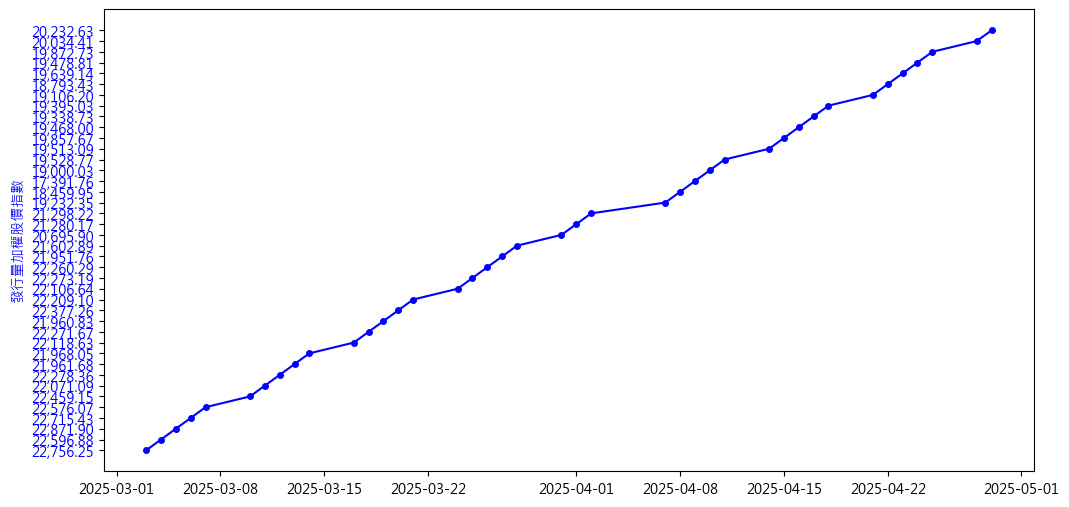

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

# === 確保數據格式正確 ===
df_merged['datetime'] = pd.to_datetime(df_merged['datetime'])

# === 建立圖表 ===
fig, ax1 = plt.subplots(figsize=(12, 6))  # 設定圖表大小

# 主要 Y 軸（左側）：發行量加權股價指數
ax1.plot(df_merged['datetime'], df_merged['發行量加權股價指數'], label='發行量加權股價指數', color='blue' , marker='o', markersize=4)
ax1.set_ylabel('發行量加權股價指數', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 副 Y 軸（右側）：年化波動率 & 臺指選擇權波動率指數
ax2 = ax1.twinx()
ax2.plot(df_merged['datetime'], df_merged['hv_annualized'], label='年化波動率 (%)', color='red',marker='o', markersize=4)
ax2.plot(df_merged['datetime'], df_merged['臺指選擇權波動率指數'], label='臺指選擇權波動率指數', color='green',marker='o', markersize=4)
ax2.set_ylabel('波動率 (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# === 設定右側 Y 軸只顯示幾個大的數值 ===
ax2.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))  # 只顯示 5 個主要數值

# === 設定圖表標題與圖例 ===
plt.title('時間 vs 股價指數 & 波動率')
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))  # 設定圖例位置
plt.xticks(rotation=45)  # 旋轉 x 軸標籤，使其更易讀

# 顯示圖表
plt.show()


In [14]:
df_filtered.to_csv('VIX_STOCK_CHANGE.csv', index = False, encoding = 'utf-8-sig')

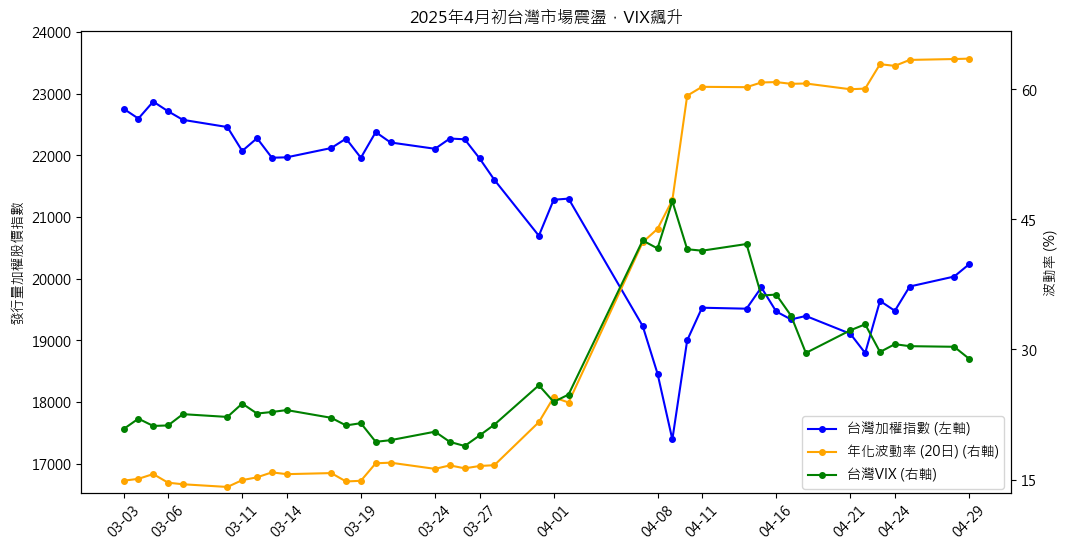

In [43]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import matplotlib.dates as mdates

df_filtered = df_merged.copy()

# === 建立圖表 ===
fig, ax1 = plt.subplots(figsize=(12, 6))  # 設定圖表大小

# 主要 Y 軸（左側）：發行量加權股價指數
ax1.plot(df_filtered['datetime'], df_filtered['收盤價'], label='台灣加權指數 (左軸)', color='blue', marker='o', markersize=4)
ax1.set_ylabel('發行量加權股價指數', color='black')
ax1.tick_params(axis='y', labelcolor='black')
# 設定 X 軸格式，只顯示 "MM-DD"
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# 每 3 天顯示一個標籤（可調整間距）
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=3))

# 旋轉 X 軸標籤以便閱讀
plt.xticks(rotation=45)

# 設定左側 Y 軸範圍
ax1.set_ylim(df_filtered['收盤價'].min() * 0.95, df_filtered['收盤價'].max() * 1.05)

# 副 Y 軸（右側）：年化波動率 & 臺指選擇權波動率指數
ax2 = ax1.twinx()
ax2.plot(df_filtered['datetime'], df_filtered['hv_annualized'], label='年化波動率 (20日) (右軸)', color='orange', marker='o', markersize=4)
ax2.plot(df_filtered['datetime'], df_filtered['臺指選擇權波動率指數'], label='台灣VIX (右軸)', color='green', marker='o', markersize=4)
ax2.set_ylabel('波動率 (%)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# 設定右側 Y 軸範圍
ax2.set_ylim(df_filtered[['hv_annualized', '臺指選擇權波動率指數']].min().min() * 0.95, 
             df_filtered[['hv_annualized', '臺指選擇權波動率指數']].max().max() * 1.05)

# 只顯示幾個主要的 Y 軸數值
ax2.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

# 取得每隔 5 天的時間標籤
xticks_labels = df_filtered["datetime"].iloc[::3]  # 每 5 個數據點選一個作為 X 軸標籤

# 設定 X 軸刻度
ax1.set_xticks(xticks_labels)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))  # 顯示 "月-日"
plt.xticks(rotation=45)  # 旋轉標籤，避免重疊


# 設定圖表標題與圖例
plt.title('2025年4月初台灣市場震盪，VIX飆升')
fig.legend(loc="upper left", bbox_to_anchor=(0.72, 0.25))  # 設定圖例位置
plt.xticks(rotation=45)  # 旋轉 x 軸標籤，使其更易讀

# 顯示圖表
plt.show()
